In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

dtype = torch.float32

device = "cuda"

from scipy import stats

In [3]:
L = 100
u = 0.01
alpha = 2.5

k1 = 1
k2 = 0.01
eps = 0.01

F0 = 1
m = 1
h = 0.1
width = 1000








def f(x,v,t,alpha,u):
    xIntoLeft = torch.roll(x,-1,dims=0)
    xIntoRight = torch.roll(x,1,dims=0)

    xIntoLeft[-1,:] = 0
    xIntoRight[0,:] = 0



    return torch.where(v==0,
    torch.where(torch.abs(-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t) < F0, -x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t ,F0*(1-eps) ),
    F0*(1-eps)/(1+alpha*torch.abs(v)/(1-eps)))


def acc(x,v,t,alpha,u):
    xIntoLeft = torch.roll(x,-1,dims=0)
    xIntoRight = torch.roll(x,1,dims=0)

    xIntoLeft[-1,:] = 0
    xIntoRight[0,:] = 0

    return (-x*(2*k1 + k2) + (xIntoRight + xIntoLeft)*k1 + k2*u*t - f(x,v,t,alpha,u) )/m


def tenstion(x,v,t,alpha,u):
    return m*acc(x,v,t,alpha,u) + f(x,v,t,alpha,u)


def step(x,v,t,alpha,u):
    t = torch.where((v ==0).all( 0),t + (F0-tenstion(x,v,t,alpha,u).max(0)[0])/(k2*u) , t)


    k_1 = v
    l_1 = acc(x,v,t,alpha,u)

    k_2 = v + l_1*h/2
    l_2 = acc(x+k_1*h/2,v + l_1*h/2,t + h/2,alpha,u)

    k_3 = v + l_2*h/2
    l_3 = acc(x+k_2*h/2,v + l_2*h/2,t + h/2,alpha,u)

    k_4 = v + l_3/2
    l_4 = acc(x+k_3*h,v + l_3*h, t + h,alpha,u)

    deltax = (k_1 + 2*k_2 + 2*k_3 + k_4)*h/6

    # x = x +  deltax

    x = x + torch.where(deltax >  0, deltax , 0  )
    v = v +  (l_1 + 2*l_2 + 2*l_3 + l_4)*h/6

    v = torch.where(v<0, 0, v)
    return x, v,t+h

def run(x,v,t,steps,alpha,u,width):
    totalX = torch.zeros((steps,width),dtype=dtype,device = device)
    slipping = torch.zeros((steps,width),dtype=dtype,device = device)
    tdata = torch.zeros((steps,width),dtype=dtype,device = device)
    for i in range(steps):
        x,v,t = step(x,v,t,alpha,u)
        totalX[i] = x.sum(0)
        slipping[i] = (v > 0 ).any(0)


    # slipping = (vdata>0).any(dim=1)

    slippingR = slipping.roll(+1,dims = 0)
    slippingL = slipping.roll(-1,dims = 0)
    slippingR[0] = False
    slippingL[-1] = False

    ends  = torch.logical_xor( slipping ,(slipping *slippingL))
    starts  = torch.logical_xor( slipping ,(slipping *slippingR))

    # totalX = xdata.sum(1)

    eventsSize = totalX.T[ends.T] - totalX.T[starts.T]

    eventsStep = (torch.argwhere(ends.T)  - torch.argwhere(starts.T))[:,1]

    # eventsTime = tdata.T[ends.T] - tdata.T[starts.T]

    # evetnsBlock = (xdata.permute(2,0,1)[ends.T] != xdata.permute(2,0,1)[starts.T]).sum(dim = 1)



    return x,v, t,eventsSize,eventsStep#,eventsTime    # ,evetnsBlock


def getData(iteration , steps ,alpha,u,width):
    means = torch.zeros(iteration)
    x = 0.1*(torch.rand((L,width),dtype=dtype,device=device) - 1)
    v = torch.zeros((L,width),dtype=dtype,device=device)
    t = torch.zeros(width,dtype=dtype,device=device)
    eventsSizes = torch.empty((0),dtype=dtype,device = device)
    eventsSteps = torch.empty((0),dtype=dtype,device = device)
    # eventsTimes = torch.empty((0),dtype=dtype,device = device)
    # evetnsBlocks = torch.empty((0),dtype=dtype,device = device)

    for i in tqdm(range(iteration)):
        x,v,t,eventsSize,eventsStep = run(x,v,t,steps,alpha,u,width)
        eventsSizes = torch.concatenate((eventsSizes,eventsSize))
        eventsSteps = torch.concatenate((eventsSteps,eventsStep))
        # eventsTimes = torch.concatenate((eventsTimes,eventsTime))
        # evetnsBlocks = torch.concatenate((evetnsBlocks,evetnsBlock))
        means[i] = eventsSize.mean()




    return  eventsSizes,eventsSteps,means

def getData2(iteration , steps ,alpha,u,width):
    means = torch.zeros(iteration)
    eventsSizes = torch.empty((0),dtype=dtype,device = device)
    eventsSteps = torch.empty((0),dtype=dtype,device = device)
    # eventsTimes = torch.empty((0),dtype=dtype,device = device)
    # evetnsBlocks = torch.empty((0),dtype=dtype,device = device)


    for i in tqdm(range(iteration)):
        x = 0.1*(torch.rand((L,width),dtype=dtype,device=device) - 1)
        v = torch.zeros((L,width),dtype=dtype,device=device)
        t = torch.zeros(width,dtype=dtype,device=device)
        x,v,t,eventsSize,eventsStep = run(x,v,t,steps,alpha,u,width)
        eventsSizes = torch.concatenate((eventsSizes,eventsSize))
        eventsSteps = torch.concatenate((eventsSteps,eventsStep))
        # eventsTimes = torch.concatenate((eventsTimes,eventsTime))
        # evetnsBlocks = torch.concatenate((evetnsBlocks,evetnsBlock))

        means[i] = eventsSize.mean()




    return  eventsSizes,eventsSteps,means


In [4]:
eventsSizes,eventsSteps,means = getData2(100,1_000,alpha,u,1000)
print(eventsSizes.shape)
eventsSizes.cpu().min()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:02<00:00,  3.03s/it]

torch.Size([714551])


tensor(0.)

In [10]:
eventsSizes2,eventsSteps2,means2 = getData(100,1_000,alpha,u,1000)
print(eventsSizes2.shape)
eventsSizes2.cpu().min()

100%|██████████| 100/100 [05:01<00:00,  3.01s/it]

torch.Size([100000])


tensor(94.0469)

In [11]:
torch.save(eventsSizes, "eventsSizes.pt")
torch.save(eventsSteps, "eventsSteps.pt")
torch.save(means, "means.pt")

torch.save(eventsSizes2, "eventsSizes2.pt")
torch.save(eventsSteps2, "eventsSteps2.pt")
torch.save(means2, "means2.pt")

In [4]:


eventsSizes = torch.load( "eventsSizes.pt", map_location=torch.device('cpu') )
eventsSteps = torch.load( "eventsSteps.pt", map_location=torch.device('cpu'))
means =  torch.load( "means.pt", map_location=torch.device('cpu'))

eventsSizes2 = torch.load("eventsSizes2.pt", map_location=torch.device('cpu'))
eventsSteps2 = torch.load("eventsSteps2.pt", map_location=torch.device('cpu'))
means2 =  torch.load( "means2.pt", map_location=torch.device('cpu'))



In [5]:
# plt.hist(eventsSizes.cpu(),bins = 20,log=True)

/tmp/ipykernel_24581/585221307.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(size[:-1]),np.log(freq))


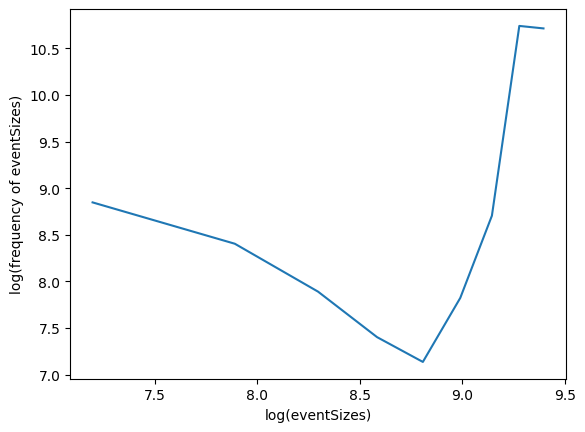

In [8]:
freq,size = np.histogram(eventsSizes.cpu())
# plt.title("log(frequency of eventSizes) vs log(eventSizes) for independent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
plt.plot(np.log(size[:-1]),np.log(freq))
# plt.savefig("fig1_1.png")


tensor([[     0],
        [     1],
        [     2],
        ...,
        [321122],
        [321123],
        [321124]])

/tmp/ipykernel_8991/3287065177.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(size[:-1],np.log(freq))
/tmp/ipykernel_8991/3287065177.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_2.png")
/tmp/ipykernel_8991/3287065177.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_2.png")
/tmp/ipykernel_8991/3287065177.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_2.png")
/tmp/ipykernel_8991/3287065177.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer supported as

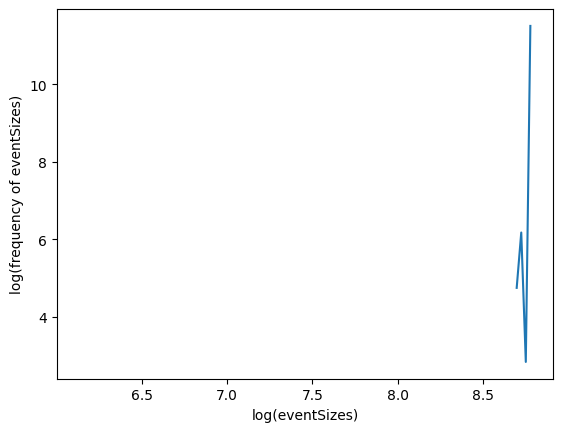

In [14]:
freq,size = np.histogram(torch.log(eventsSizes2[eventsSizes2 != 0].cpu()),bins=100)
# plt.title("log(frequency of eventSizes) vs log(eventSizes) for dependent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
plt.plot(size[:-1],np.log(freq))
plt.savefig("fig1_2.png")

/tmp/ipykernel_8991/2170374505.py:5: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(size[:-1]),np.log(freq))
/tmp/ipykernel_8991/2170374505.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_2.png")
/tmp/ipykernel_8991/2170374505.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_2.png")
/tmp/ipykernel_8991/2170374505.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("fig1_2.png")
/tmp/ipykernel_8991/2170374505.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inches_restore" which is no longer s

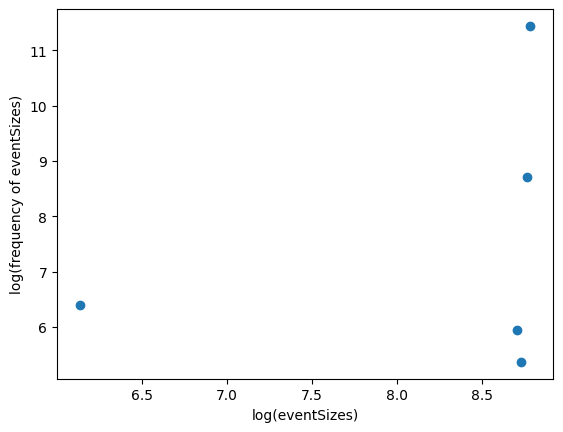

In [13]:
freq,size = np.histogram(eventsSizes2.cpu(),bins=50)
# plt.title("log(frequency of eventSizes) vs log(eventSizes) for dependent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
plt.scatter(np.log(size[:-1]),np.log(freq))
plt.savefig("fig1_2.png")

tensor([1.4533e-01, 1.4533e-01, 1.4534e-01,  ..., 1.1711e+01, 6.1719e-01,
        6.5062e+02])

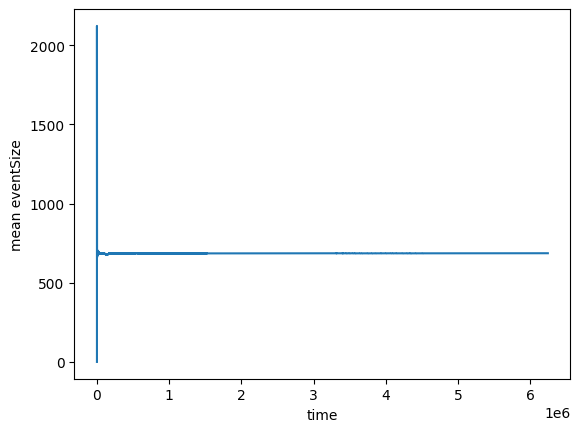

In [ ]:
ev = eventsSizes.cpu()
# plt.title("mean eventSize vs time for independent sampling")
plt.xlabel("time")
plt.ylabel("mean eventSize")
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
plt.savefig("fig2_1.png")

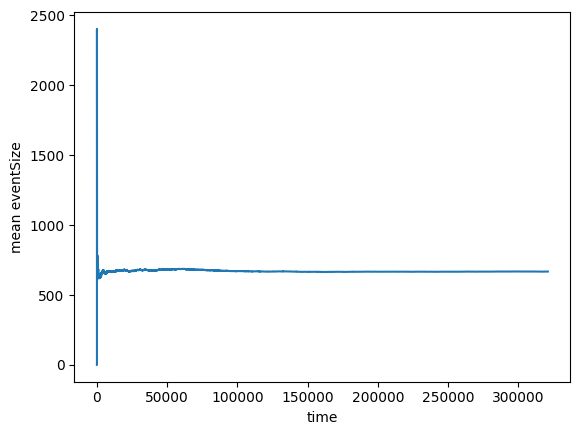

In [ ]:
ev = eventsSizes2.cpu()
# plt.title("mean eventSize vs time for dependent sampling")
plt.xlabel("time")
plt.ylabel("mean eventSize")
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
plt.savefig("fig2_2.png")

In [ ]:
# ev = eventsSizes3.cpu()
# plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())

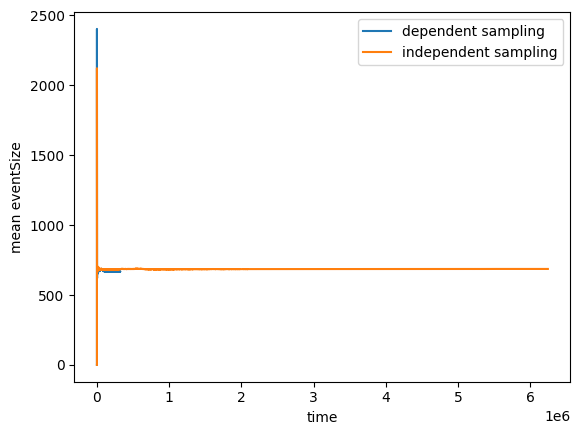

In [ ]:
# plt.title("mean eventSize vs time")
plt.xlabel("time")
plt.ylabel("mean eventSize")
ev = eventsSizes2.cpu()
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
ev = eventsSizes.cpu()
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
plt.legend(["dependent sampling","independent sampling"])
plt.savefig("fig2_3.png")
# ev = eventsSizes3.cpu()
# plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())

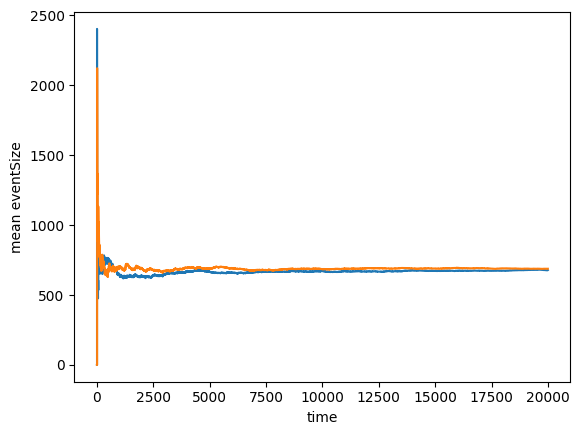

In [ ]:
# plt.title("mean eventSize vs time ( zoomed)")
plt.xlabel("time")
plt.ylabel("mean eventSize")
index = 20_000
ev = eventsSizes2.cpu()[:index]
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
ev = eventsSizes.cpu()[:index]
plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())
plt.savefig("fig2_4.png")
# ev = eventsSizes3.cpu()[:index]
# plt.plot(np.arange(ev.shape[0]) , (ev.cumsum(dim=0) / torch.arange(1, ev.shape[0] + 1 )).cpu())

In [ ]:
# freq,size = np.histogram(eventsSizes.cpu(),bins=np.logspace(np.log10(eventsSizes.cpu()[eventsSizes.cpu().nonzero()].min()),np.log10((eventsSizes.cpu().max())),50))
# plt.scatter(np.log(size[:-1]),np.log(freq))

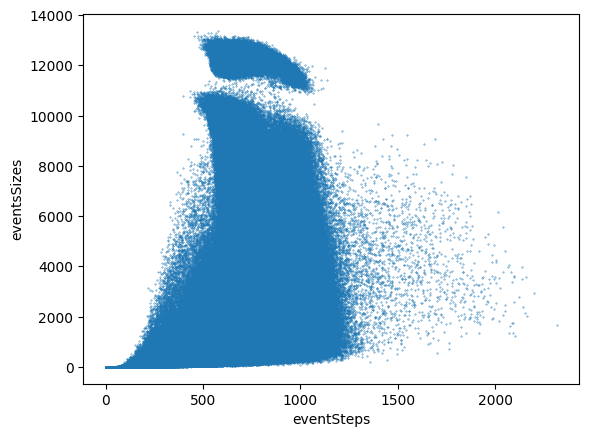

In [ ]:
# plt.title(" eventsSizes vs eventSteps for independent sampling")
plt.xlabel("eventSteps")
plt.ylabel("eventsSizes")
plt.scatter(eventsSteps.cpu(),eventsSizes.cpu(),s= 0.1)
plt.savefig("fig3_1.png")

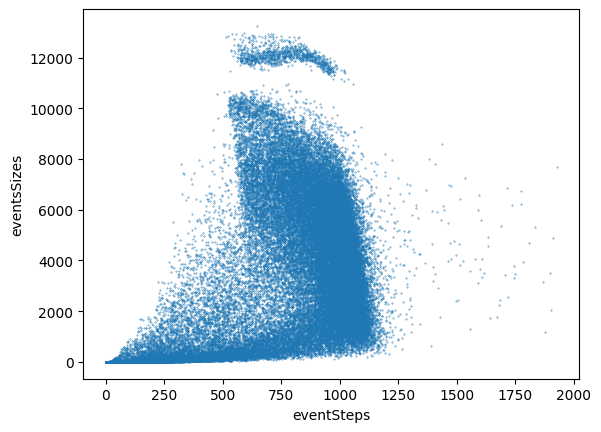

In [ ]:
# plt.title(" eventsSizes vs eventSteps for dependent sampling")
plt.xlabel("eventSteps")
plt.ylabel("eventsSizes")
plt.scatter(eventsSteps2.cpu(),eventsSizes2.cpu(),s= 0.1)
plt.savefig("fig3_2.png")

In [ ]:
# plt.scatter(torch.log(eventsSizes.cpu()),torch.log(eventsSteps.cpu() ), s= 0.1)

In [ ]:
# plt.scatter(torch.log(eventsSizes2.cpu()),torch.log(eventsSteps2.cpu() ), s= 0.1)

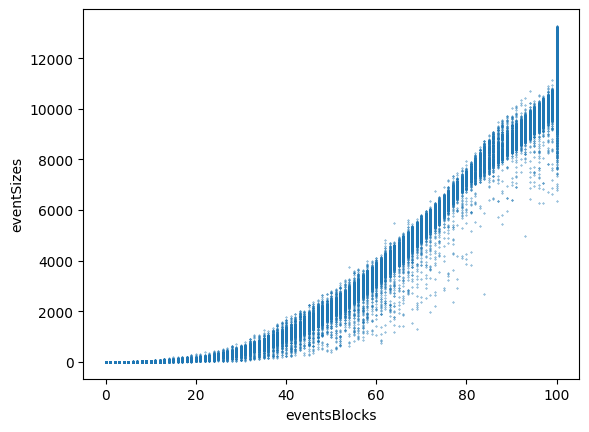

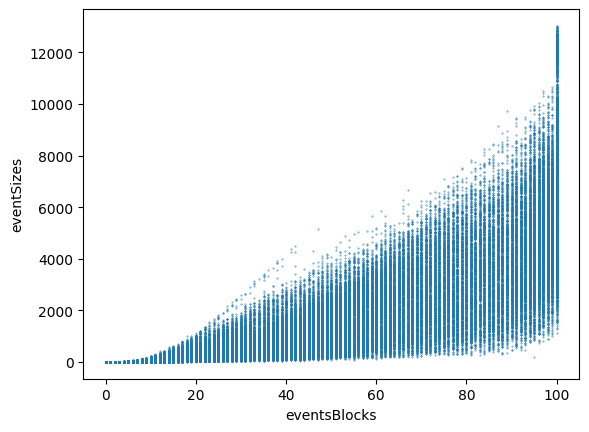

In [ ]:
# plt.title(" eventsSteps vs eventBlocks for independent sampling")
plt.xlabel("eventsBlocks")
plt.ylabel("eventSizes")


plt.scatter(evetnsBlocks1.cpu(),eventsSizes.cpu(), s= 0.1)
plt.savefig("fig4_1.png")
plt.show()


# plt.title(" eventsSteps vs eventBlocks for dependent sampling")
plt.xlabel("eventsBlocks")
plt.ylabel("eventSizes")
plt.scatter(evetnsBlocks.cpu(),eventsSizes2.cpu(), s= 0.1)
plt.savefig("fig4_2.png")


NameError: name 'evetnsBlocks' is not defined

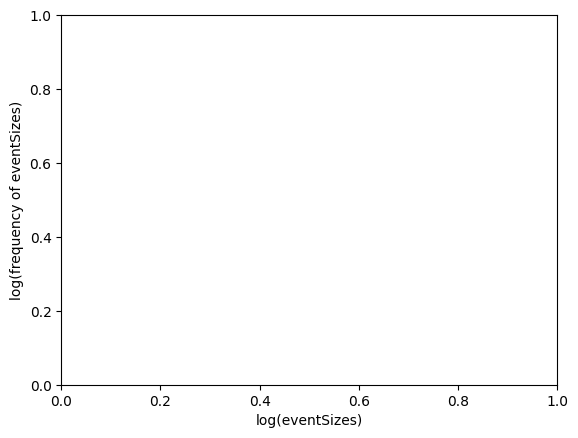

In [ ]:
# plt.title("log(frequency of eventSizes) vs log(eventSizes) for dependent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
filtered = eventsSizes2[torch.argwhere(evetnsBlocks != 100)].cpu()
freq,size = np.histogram(filtered,bins=50)
plt.plot(np.log(size[:-1]),np.log(freq))
plt.savefig("fig5_1.png")
plt.show()


# plt.title("log(frequency of eventSizes) vs log(eventSizes) for independent sampling")
plt.xlabel("log(eventSizes)")
plt.ylabel("log(frequency of eventSizes)")
filtered = eventsSizes[torch.argwhere(evetnsBlocks1 != 100)].cpu()
freq,size = np.histogram(filtered,bins=50)
plt.plot(np.log(size[:-1]),np.log(freq))
plt.savefig("fig5_2.png")


In [ ]:
torch.save(eventsSizes2, "eventsSizes2.pt")
torch.save(eventsSteps2, "eventsSteps2.pt")
torch.save(eventsTimes2, "eventsTimes2.pt")
torch.save(means2, "means2.pt")

torch.save(eventsSizes, "eventsSizes.pt")
torch.save(eventsSteps, "eventsSteps.pt")
torch.save(eventsTimes, "eventsTimes.pt")
torch.save(means, "means.pt")


files.download("eventsSizes2.pt")
files.download("eventsSteps2.pt")
files.download("eventsTimes2.pt")
files.download("means2.pt")

files.download("eventsSizes.pt")
files.download("eventsSteps.pt")
files.download("eventsTimes.pt")
files.download("means.pt")

files.download("fig1_1.png")
files.download("fig1_2.png")
files.download("fig2_1.png")
files.download("fig2_2.png")
files.download("fig2_3.png")
files.download("fig2_4.png")
files.download("fig3_1.png")
files.download("fig3_2.png")
files.download("fig4_1.png")
files.download("fig4_2.png")
files.download("fig5_1.png")
files.download("fig5_2.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("fig4_1.png")
files.download("fig4_2.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>